# Somatotopic Decoding Analysis

**Dataset:**
- **Participants:** sub-p0001, sub-p0002
- **Runs per subject:** 4
- **Total samples:** 320 (160 per subject)
- **Electrodes:** 20 (E1-E20)
- **Samples per electrode:** 16 total (8 per subject)

**Analysis:**
1. **Leave-One-Run-Out Cross-Validation:** 8 folds, training on 7 runs (280 samples = 14 per electrode)
2. **20-way electrode classification:** Tests fine-grained somatotopic mapping
3. **Binary contrasts:** Tests anatomical gradients at different spatial scales

In [17]:
import json
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn.image import load_img, index_img, mean_img, resample_to_img
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.image import new_img_like
from nilearn import plotting
from nilearn.maskers import NiftiMasker

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, cohen_kappa_score

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [18]:
BIDS_ROOT = Path(r"C:/Users/duart/Desktop/Tese/Mapping_Tese/mapping_tese/data/BIDS-somatosensory/BIDS-somatosensory")
DERIVATIVES = BIDS_ROOT / "derivatives" / "fmriprep"

subjects = ["sub-p0001", "sub-p0002"]
session = "ses-01"
task = "task-S1Map"
space = "MNI152NLin2009cAsym"
n_runs_per_subject = 4


HRF_DELAY = 5.0
WINDOW = 1

bold_json = BIDS_ROOT / subjects[0] / session / "func" / f"{subjects[0]}_{session}_{task}_run-1_bold.json"
with open(bold_json, 'r', encoding='utf-8') as f:
    tr = float(json.load(f)["RepetitionTime"])

print(f"Subjects: {subjects}")
print(f"Runs per subject: {n_runs_per_subject}")
print(f"Total runs: {len(subjects) * n_runs_per_subject}")
print(f"TR: {tr} s")
print(f"HRF delay: {HRF_DELAY} s")
print(f"Window: {WINDOW} volumes")

Subjects: ['sub-p0001', 'sub-p0002']
Runs per subject: 4
Total runs: 8
TR: 2.0 s
HRF delay: 5.0 s
Window: 1 volumes


In [19]:
RESULTS_DIR = Path("results_02_decoding_combined")
FIGURES_DIR = RESULTS_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_LOG = RESULTS_DIR / "analysis_log.txt"
log_file = open(OUTPUT_LOG, 'w', encoding='utf-8')

original_print = print
def print(*args, **kwargs):
    original_print(*args, **kwargs)
    original_print(*args, **kwargs, file=log_file, flush=True)

print(f"Results directory: {RESULTS_DIR.resolve()}")
print(f"Figures directory: {FIGURES_DIR.resolve()}")
print(f"Output log: {OUTPUT_LOG.resolve()}")
print("="*70)

Results directory: C:\Users\duart\Desktop\Tese\Mapping_Tese\mapping_tese\notebooks\results_02_decoding_combined
Figures directory: C:\Users\duart\Desktop\Tese\Mapping_Tese\mapping_tese\notebooks\results_02_decoding_combined\figures
Output log: C:\Users\duart\Desktop\Tese\Mapping_Tese\mapping_tese\notebooks\results_02_decoding_combined\analysis_log.txt


## Load Events from Both Subjects

In [20]:
all_events = []
for subject in subjects:
    for run in range(1, n_runs_per_subject + 1):
        events_path = BIDS_ROOT / subject / session / "func" / f"{subject}_{session}_{task}_run-{run}_events.tsv"
        df = pd.read_csv(events_path, sep='\t')
        df['subject'] = subject
        df['run'] = run
        df['global_run'] = run if subject == subjects[0] else (run + n_runs_per_subject)
        all_events.append(df)

events_df = pd.concat(all_events, ignore_index=True)
stim_events = events_df[~events_df['trial_type'].isin(['Baseline', 'Jitter'])].copy()

print(f"Total events: {len(events_df)}")
print(f"Stimulation events: {len(stim_events)}")
print(f"Unique electrodes: {stim_events['trial_type'].nunique()}")
print(f"\nSamples per subject:")
print(stim_events.groupby('subject').size())
print(f"\nSamples per global run:")
print(stim_events.groupby('global_run').size().to_dict())
print(f"\nSamples per electrode (pooled):")
electrode_counts = stim_events['trial_type'].value_counts().sort_index()
print(f"  Min: {electrode_counts.min()}, Max: {electrode_counts.max()}, Mean: {electrode_counts.mean():.1f}")

Total events: 656
Stimulation events: 320
Unique electrodes: 20

Samples per subject:
subject
sub-p0001    160
sub-p0002    160
dtype: int64

Samples per global run:
{1: 40, 2: 40, 3: 40, 4: 40, 5: 40, 6: 40, 7: 40, 8: 40}

Samples per electrode (pooled):
  Min: 16, Max: 16, Mean: 16.0


In [21]:
first_run_path = (DERIVATIVES / subjects[0] / session / "func" /
                  f"{subjects[0]}_{session}_{task}_run-1_space-{space}_desc-preproc_bold.nii.gz")
first_run_img = load_img(str(first_run_path))
ref_img = index_img(first_run_img, 0)
print(f"Reference image shape: {first_run_img.shape}")

atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
s1_indices = [i for i, lab in enumerate(atlas.labels) if 'Postcentral Gyrus' in str(lab) and i != 0]
if len(s1_indices) == 0 and 'Postcentral Gyrus' in atlas.labels:
    s1_indices = [atlas.labels.index('Postcentral Gyrus')]

atlas_img = atlas.maps
atlas_data = atlas_img.get_fdata()
mask_data = np.isin(atlas_data, s1_indices).astype('uint8')
s1_mask = new_img_like(atlas_img, mask_data)
s1_mask_resampled = resample_to_img(s1_mask, ref_img, interpolation='nearest')
masker = NiftiMasker(mask_img=s1_mask_resampled, standardize=False).fit()

print(f"\nS1 atlas indices: {s1_indices}")
print('Selected atlas regions:')
for i in s1_indices:
    print(f"  - {atlas.labels[i]}")
print(f"\nNumber of voxels in S1 mask: {int(np.sum(mask_data))}")

display = plotting.plot_roi(s1_mask_resampled, bg_img=ref_img, 
                            title='S1 ROI Mask (Postcentral Gyrus)',
                            display_mode='ortho', cut_coords=(0, -20, 60))
display.savefig(FIGURES_DIR / 's1_mask.png', dpi=150)
display.close()
print(f"\nS1 mask saved to: {FIGURES_DIR / 's1_mask.png'}")

Reference image shape: (121, 144, 121, 250)
[fetch_atlas_harvard_oxford] Dataset found in C:\Users\duart\nilearn_data\fsl


C:\Users\duart\AppData\Local\Temp\ipykernel_18900\932417415.py:16: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  s1_mask_resampled = resample_to_img(s1_mask, ref_img, interpolation='nearest')
C:\Users\duart\AppData\Local\Temp\ipykernel_18900\932417415.py:16: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  s1_mask_resampled = resample_to_img(s1_mask, ref_img, interpolation='nearest')



S1 atlas indices: [17]
Selected atlas regions:
  - Postcentral Gyrus

Number of voxels in S1 mask: 6895

S1 mask saved to: results_02_decoding_combined\figures\s1_mask.png


In [22]:
feature_rows = []
labels = []
groups = []
subject_ids = []

for subject in subjects:
    for run in range(1, n_runs_per_subject + 1):
        func_path = (DERIVATIVES / subject / session / "func" /
                     f"{subject}_{session}_{task}_run-{run}_space-{space}_desc-preproc_bold.nii.gz")
        img = load_img(str(func_path))
        run_length = img.shape[3]
        
        run_events = stim_events[
            (stim_events['subject'] == subject) & 
            (stim_events['run'] == run)
        ].sort_values('onset')
        
        global_run = run if subject == subjects[0] else (run + n_runs_per_subject)
        
        print(f"{subject} run {run} (global {global_run}): {img.shape}, {len(run_events)} events")

        for _, ev in run_events.iterrows():
            peak_vol = int(np.round((float(ev['onset']) + HRF_DELAY) / tr))
            if peak_vol >= run_length:
                continue

            vols = list(range(max(0, peak_vol - WINDOW), min(run_length, peak_vol + WINDOW + 1)))
            averaged = mean_img(index_img(img, vols))
            row = masker.transform(averaged)
            feature_rows.append(row.ravel())
            labels.append(str(ev['trial_type']))
            groups.append(global_run)
            subject_ids.append(subject)

X_features = np.vstack(feature_rows)
y = np.asarray(labels)
groups = np.asarray(groups)
subject_ids = np.asarray(subject_ids)

print('\n' + '='*70)
print('FEATURE EXTRACTION SUMMARY')
print('='*70)
print(f'Feature matrix shape: {X_features.shape}')
print(f'Total samples: {len(y)}')
print(f'Number of classes: {len(np.unique(y))}')
print(f'Global runs: {list(np.unique(groups))}')
print(f'Samples per electrode: {len(y) / len(np.unique(y)):.1f}')
print(f'Samples per subject: {dict(pd.Series(subject_ids).value_counts())}')

logo = LeaveOneGroupOut()
n_folds = logo.get_n_splits(groups=groups)
samples_per_fold_train = (len(y) * (n_folds - 1)) / n_folds
samples_per_fold_test = len(y) / n_folds

print(f'\nCross-validation setup:')
print(f'  Method: Leave-One-Run-Out (LORO)')
print(f'  Number of folds: {n_folds}')
print(f'  Training samples per fold: {samples_per_fold_train:.0f} ({samples_per_fold_train / len(np.unique(y)):.1f} per electrode)')
print(f'  Test samples per fold: {samples_per_fold_test:.0f} ({samples_per_fold_test / len(np.unique(y)):.1f} per electrode)')
print('='*70)

sub-p0001 run 1 (global 1): (121, 144, 121, 250), 40 events


C:\Users\duart\AppData\Local\Temp\ipykernel_18900\663603219.py:28: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  averaged = mean_img(index_img(img, vols))


sub-p0001 run 2 (global 2): (121, 144, 121, 250), 40 events


C:\Users\duart\AppData\Local\Temp\ipykernel_18900\663603219.py:28: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  averaged = mean_img(index_img(img, vols))


sub-p0001 run 3 (global 3): (121, 144, 121, 250), 40 events


C:\Users\duart\AppData\Local\Temp\ipykernel_18900\663603219.py:28: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  averaged = mean_img(index_img(img, vols))


sub-p0001 run 4 (global 4): (121, 144, 121, 250), 40 events


C:\Users\duart\AppData\Local\Temp\ipykernel_18900\663603219.py:28: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  averaged = mean_img(index_img(img, vols))


sub-p0002 run 1 (global 5): (121, 144, 121, 250), 40 events


C:\Users\duart\AppData\Local\Temp\ipykernel_18900\663603219.py:28: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  averaged = mean_img(index_img(img, vols))


sub-p0002 run 2 (global 6): (121, 144, 121, 250), 40 events


C:\Users\duart\AppData\Local\Temp\ipykernel_18900\663603219.py:28: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  averaged = mean_img(index_img(img, vols))


sub-p0002 run 3 (global 7): (121, 144, 121, 250), 40 events


C:\Users\duart\AppData\Local\Temp\ipykernel_18900\663603219.py:28: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  averaged = mean_img(index_img(img, vols))


sub-p0002 run 4 (global 8): (121, 144, 121, 250), 40 events


C:\Users\duart\AppData\Local\Temp\ipykernel_18900\663603219.py:28: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  averaged = mean_img(index_img(img, vols))



FEATURE EXTRACTION SUMMARY
Feature matrix shape: (320, 13434)
Total samples: 320
Number of classes: 20
Global runs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Samples per electrode: 16.0
Samples per subject: {'sub-p0001': np.int64(160), 'sub-p0002': np.int64(160)}

Cross-validation setup:
  Method: Leave-One-Run-Out (LORO)
  Number of folds: 8
  Training samples per fold: 280 (14.0 per electrode)
  Test samples per fold: 40 (2.0 per electrode)




Can individual electrodes be decoded from S1 activity patterns using Linear SVM with LORO cross-validation?

In [23]:
clf = LinearSVC(C=1.0, class_weight=None, dual='auto', max_iter=20000, random_state=RANDOM_SEED)
pipe = Pipeline(steps=[('scale', StandardScaler(with_mean=True, with_std=True)), ('clf', clf)])

all_classes = np.unique(y)
y_pred = np.empty_like(y, dtype=object)
fold_acc = []
fold_bacc = []

print("=" * 70)
print("20-WAY ELECTRODE CLASSIFICATION (LORO CV)")
print("=" * 70)

for fold_i, (train_idx, test_idx) in enumerate(logo.split(X_features, y, groups), 1):
    left_out = int(np.unique(groups[test_idx])[0])
    test_subject = subject_ids[test_idx][0]
    
    X_train = X_features[train_idx]
    X_test = X_features[test_idx]

    pipe.fit(X_train, y[train_idx])
    y_pred[test_idx] = pipe.predict(X_test)

    acc = accuracy_score(y[test_idx], y_pred[test_idx])
    bacc = balanced_accuracy_score(y[test_idx], y_pred[test_idx])
    fold_acc.append(acc)
    fold_bacc.append(bacc)

    print(f"Fold {fold_i} (run {left_out}, {test_subject}): "
          f"train_n={len(train_idx)}, acc={acc:.3f}, bacc={bacc:.3f}")

fold_acc = np.asarray(fold_acc)
fold_bacc = np.asarray(fold_bacc)
mean_accuracy = float(fold_acc.mean())
std_accuracy = float(fold_acc.std())
mean_bacc = float(fold_bacc.mean())
std_bacc = float(fold_bacc.std())
chance_level = 1.0 / len(all_classes)

print("=" * 70)
print(f"Mean accuracy:          {mean_accuracy:.4f} +/- {std_accuracy:.4f}")
print(f"Mean balanced accuracy: {mean_bacc:.4f} +/- {std_bacc:.4f}")
print(f"Chance level:           {chance_level:.4f} (5.0%)")
print(f"Above chance:           {(mean_bacc - chance_level) / chance_level * 100:+.1f}%")
print("=" * 70)

20-WAY ELECTRODE CLASSIFICATION (LORO CV)
Fold 1 (run 1, sub-p0001): train_n=280, acc=0.050, bacc=0.050
Fold 2 (run 2, sub-p0001): train_n=280, acc=0.100, bacc=0.100
Fold 3 (run 3, sub-p0001): train_n=280, acc=0.025, bacc=0.025
Fold 4 (run 4, sub-p0001): train_n=280, acc=0.075, bacc=0.075
Fold 5 (run 5, sub-p0002): train_n=280, acc=0.075, bacc=0.075
Fold 6 (run 6, sub-p0002): train_n=280, acc=0.075, bacc=0.075
Fold 7 (run 7, sub-p0002): train_n=280, acc=0.075, bacc=0.075
Fold 8 (run 8, sub-p0002): train_n=280, acc=0.075, bacc=0.075
Mean accuracy:          0.0688 +/- 0.0207
Mean balanced accuracy: 0.0688 +/- 0.0207
Chance level:           0.0500 (5.0%)
Above chance:           +37.5%


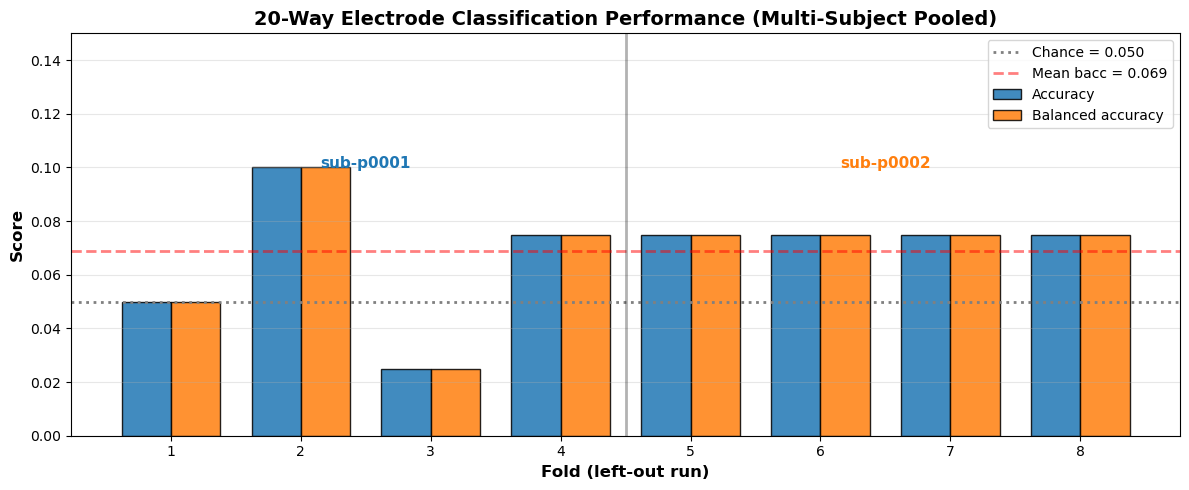

Figure saved to: results_02_decoding_combined\figures\20way_performance.png


In [24]:
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(1, len(fold_acc) + 1)
width = 0.38

colors_acc = ['#1f77b4' ]
colors_bacc = ['#ff7f0e']

ax.bar(x - width / 2, fold_acc, width=width, color=colors_acc, alpha=0.85, 
       edgecolor='black', label='Accuracy')
ax.bar(x + width / 2, fold_bacc, width=width, color=colors_bacc, alpha=0.85, 
       edgecolor='black', label='Balanced accuracy')
ax.axhline(chance_level, linestyle=':', linewidth=2, color='gray', 
           label=f'Chance = {chance_level:.3f}')
ax.axhline(mean_bacc, linestyle='--', linewidth=2, color='red', alpha=0.5, 
           label=f'Mean bacc = {mean_bacc:.3f}')
ax.axvline(4.5, linestyle='-', linewidth=2, color='black', alpha=0.3)

y_pos = ax.get_ylim()[1] * 0.95
ax.text(2.5, y_pos, 'sub-p0001', ha='center', fontweight='bold', fontsize=11, color='#1f77b4')
ax.text(6.5, y_pos, 'sub-p0002', ha='center', fontweight='bold', fontsize=11, color='#ff7f0e')

ax.set_xlabel('Fold (left-out run)', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('20-Way Electrode Classification Performance (Multi-Subject Pooled)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_ylim(0, max(0.15, max(fold_bacc) * 1.15))
ax.grid(axis='y', alpha=0.3)
ax.legend(loc='upper right')
plt.tight_layout()
fig.savefig(FIGURES_DIR / '20way_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {FIGURES_DIR / '20way_performance.png'}")

## Confusion Matrix

PER-ELECTRODE ACCURACY
E1: 0.125
E10: 0.062
E11: 0.000
E12: 0.000
E13: 0.125
E14: 0.125
E15: 0.125
E16: 0.062
E17: 0.188
E18: 0.000
E19: 0.125
E2: 0.000
E20: 0.000
E3: 0.125
E4: 0.125
E5: 0.062
E6: 0.125
E7: 0.000
E8: 0.000
E9: 0.000

Mean per-electrode accuracy: 0.069
Std per-electrode accuracy:  0.062


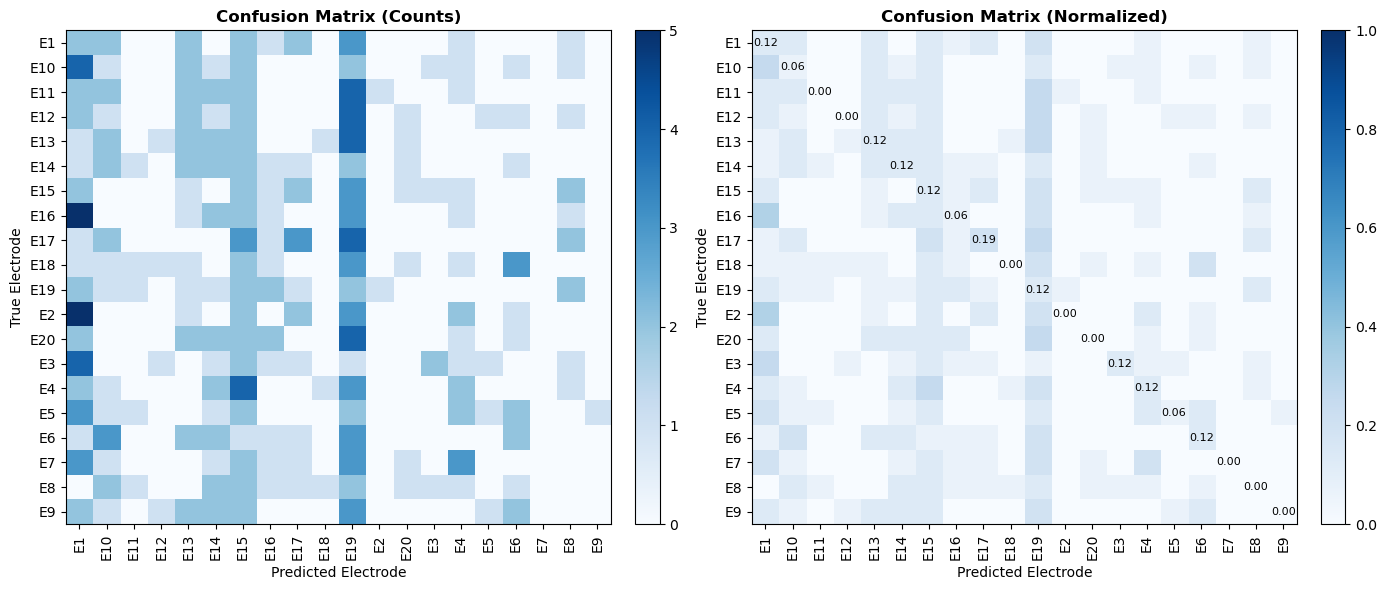


Figure saved to: results_02_decoding_combined\figures\20way_confusion_matrix.png


In [25]:
cm = confusion_matrix(y, y_pred, labels=all_classes)
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, np.where(row_sums == 0, 1, row_sums))

per_class_acc = np.diag(cm_norm)
print("=" * 70)
print("PER-ELECTRODE ACCURACY")
print("=" * 70)
for cls, acc in zip(all_classes, per_class_acc):
    print(f"{cls}: {float(acc):.3f}")
print(f"\nMean per-electrode accuracy: {per_class_acc.mean():.3f}")
print(f"Std per-electrode accuracy:  {per_class_acc.std():.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(cm, cmap='Blues', aspect='auto')
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_xticks(np.arange(len(all_classes)))
axes[0].set_yticks(np.arange(len(all_classes)))
axes[0].set_xticklabels(all_classes, rotation=90)
axes[0].set_yticklabels(all_classes)
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(cm_norm, cmap='Blues', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
axes[1].set_xticks(np.arange(len(all_classes)))
axes[1].set_yticks(np.arange(len(all_classes)))
axes[1].set_xticklabels(all_classes, rotation=90)
axes[1].set_yticklabels(all_classes)
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

for i in range(len(all_classes)):
    val = float(cm_norm[i, i])
    color = 'white' if val > 0.5 else 'black'
    axes[1].text(i, i, f"{val:.2f}", ha='center', va='center', fontsize=8, color=color)

for ax in axes:
    ax.set_xlabel('Predicted Electrode')
    ax.set_ylabel('True Electrode')

plt.tight_layout()
fig.savefig(FIGURES_DIR / '20way_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {FIGURES_DIR / '20way_confusion_matrix.png'}")

### Binary Contrast: Finger vs. Arm

- **Finger (E1-E3):** Most distal region
- **Arm (E14-E20):** Most proximal region

In [26]:
finger_electrodes = ['E1', 'E2', 'E3']
arm_electrodes = ['E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20']

binary_mask = np.isin(y, finger_electrodes + arm_electrodes)
X_binary = X_features[binary_mask]
y_binary = np.where(np.isin(y[binary_mask], finger_electrodes), 0, 1)
groups_binary = groups[binary_mask]

print("="*70)
print("BINARY CONTRAST: FINGER vs. ARM")
print("="*70)
print(f"Finger samples: {np.sum(y_binary == 0)}")
print(f"Arm samples:    {np.sum(y_binary == 1)}")
print(f"Total samples:  {len(y_binary)}")

logo_binary = LeaveOneGroupOut()
fold_acc_binary = []
fold_bacc_binary = []
all_preds_binary = []
all_labels_binary = []

for fold_i, (train_idx, test_idx) in enumerate(logo_binary.split(X_binary, y_binary, groups=groups_binary), 1):
    pipe.fit(X_binary[train_idx], y_binary[train_idx])
    y_pred_bin = pipe.predict(X_binary[test_idx])
    
    acc = accuracy_score(y_binary[test_idx], y_pred_bin)
    bacc = balanced_accuracy_score(y_binary[test_idx], y_pred_bin)
    fold_acc_binary.append(acc)
    fold_bacc_binary.append(bacc)
    all_preds_binary.extend(y_pred_bin)
    all_labels_binary.extend(y_binary[test_idx])

overall_bacc_binary = np.mean(fold_bacc_binary)
overall_f1_binary = f1_score(all_labels_binary, all_preds_binary, average='binary')
overall_kappa_binary = cohen_kappa_score(all_labels_binary, all_preds_binary)

print(f"\nBalanced Accuracy: {overall_bacc_binary:.3f} +/- {np.std(fold_bacc_binary):.3f}")
print(f"F1 Score:          {overall_f1_binary:.3f}")
print(f"Cohen's Kappa:     {overall_kappa_binary:.3f}")
print(f"Chance level:      0.500")
print(f"Above chance:      +{(overall_bacc_binary - 0.5) / 0.5 * 100:.1f}%")
print("="*70)

BINARY CONTRAST: FINGER vs. ARM
Finger samples: 48
Arm samples:    112
Total samples:  160

Balanced Accuracy: 0.644 +/- 0.136
F1 Score:          0.778
Cohen's Kappa:     0.284
Chance level:      0.500
Above chance:      +28.9%


### Binary Contrast: Hand vs. Arm

- **Hand (E4-E7):** Intermediate distal region
- **Arm (E14-E20):** Most proximal region

In [27]:
hand_electrodes = ['E4', 'E5', 'E6', 'E7']
arm_electrodes_ha = ['E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20']

binary_mask_ha = np.isin(y, hand_electrodes + arm_electrodes_ha)
X_binary_ha = X_features[binary_mask_ha]
y_binary_ha = np.where(np.isin(y[binary_mask_ha], hand_electrodes), 0, 1)
groups_binary_ha = groups[binary_mask_ha]

print("="*70)
print("BINARY CONTRAST: HAND vs. ARM")
print("="*70)

logo_binary_ha = LeaveOneGroupOut()
fold_bacc_binary_ha = []
all_preds_binary_ha = []
all_labels_binary_ha = []

for train_idx, test_idx in logo_binary_ha.split(X_binary_ha, y_binary_ha, groups=groups_binary_ha):
    pipe.fit(X_binary_ha[train_idx], y_binary_ha[train_idx])
    y_pred_ha = pipe.predict(X_binary_ha[test_idx])
    bacc = balanced_accuracy_score(y_binary_ha[test_idx], y_pred_ha)
    fold_bacc_binary_ha.append(bacc)
    all_preds_binary_ha.extend(y_pred_ha)
    all_labels_binary_ha.extend(y_binary_ha[test_idx])

overall_bacc_binary_ha = np.mean(fold_bacc_binary_ha)
print(f"Balanced Accuracy: {overall_bacc_binary_ha:.3f} +/- {np.std(fold_bacc_binary_ha):.3f}")
print(f"Above chance:      +{(overall_bacc_binary_ha - 0.5) / 0.5 * 100:.1f}%")
print("="*70)

BINARY CONTRAST: HAND vs. ARM
Balanced Accuracy: 0.594 +/- 0.065
Above chance:      +18.8%


### Binary Contrast: Forearm vs. Arm

Testing adjacent proximal regions (hardest contrast):
- **Forearm (E8-E13)**
- **Arm (E14-E20)**

In [28]:
forearm_electrodes = ['E8', 'E9', 'E10', 'E11', 'E12', 'E13']
arm_electrodes_fa = ['E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20']

binary_mask_fa = np.isin(y, forearm_electrodes + arm_electrodes_fa)
X_binary_fa = X_features[binary_mask_fa]
y_binary_fa = np.where(np.isin(y[binary_mask_fa], forearm_electrodes), 0, 1)
groups_binary_fa = groups[binary_mask_fa]

print("="*70)
print("BINARY CONTRAST: FOREARM vs. ARM")
print("="*70)

logo_binary_fa = LeaveOneGroupOut()
fold_bacc_binary_fa = []
all_preds_binary_fa = []
all_labels_binary_fa = []

for train_idx, test_idx in logo_binary_fa.split(X_binary_fa, y_binary_fa, groups=groups_binary_fa):
    pipe.fit(X_binary_fa[train_idx], y_binary_fa[train_idx])
    y_pred_fa = pipe.predict(X_binary_fa[test_idx])
    bacc = balanced_accuracy_score(y_binary_fa[test_idx], y_pred_fa)
    fold_bacc_binary_fa.append(bacc)
    all_preds_binary_fa.extend(y_pred_fa)
    all_labels_binary_fa.extend(y_binary_fa[test_idx])

overall_bacc_binary_fa = np.mean(fold_bacc_binary_fa)
print(f"Balanced Accuracy: {overall_bacc_binary_fa:.3f} +/- {np.std(fold_bacc_binary_fa):.3f}")
print(f"Above chance:      +{(overall_bacc_binary_fa - 0.5) / 0.5 * 100:.1f}%")
print("="*70)

BINARY CONTRAST: FOREARM vs. ARM
Balanced Accuracy: 0.519 +/- 0.057
Above chance:      +3.9%


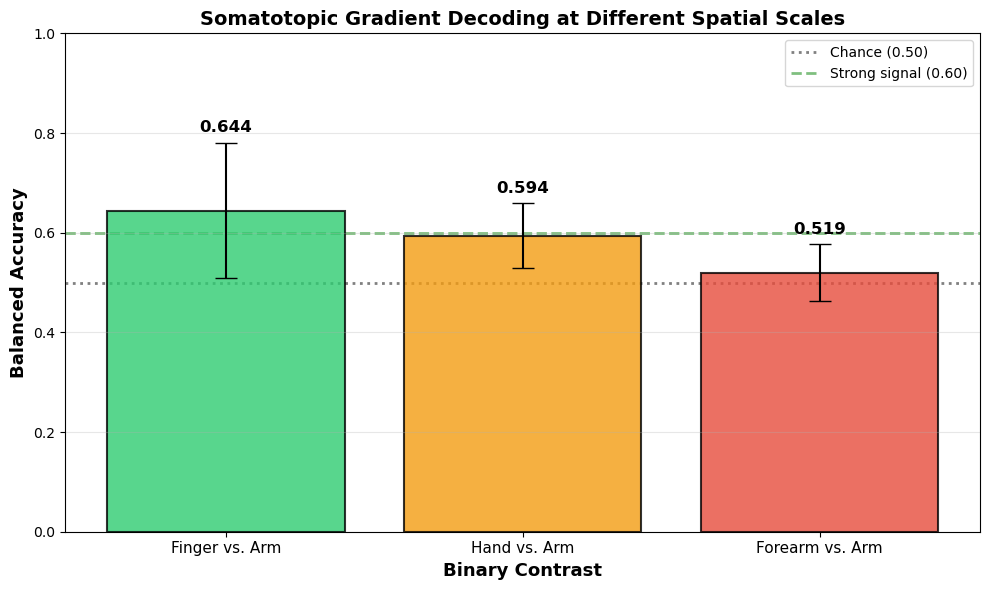


Figure saved to: results_02_decoding_combined\figures\binary_contrasts_summary.png


In [29]:
contrast_names = ['Finger vs. Arm', 'Hand vs. Arm', 'Forearm vs. Arm']
balanced_accs = [overall_bacc_binary, overall_bacc_binary_ha, overall_bacc_binary_fa]
balanced_stds = [np.std(fold_bacc_binary), np.std(fold_bacc_binary_ha), np.std(fold_bacc_binary_fa)]

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(contrast_names))
colors = ['#2ecc71' if bacc > 0.60 else '#f39c12' if bacc > 0.55 else '#e74c3c' 
          for bacc in balanced_accs]

bars = ax.bar(x_pos, balanced_accs, yerr=balanced_stds, capsize=8, 
              color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

for i, (bar, bacc, std) in enumerate(zip(bars, balanced_accs, balanced_stds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.015,
            f'{bacc:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.axhline(0.50, linestyle=':', linewidth=2, color='gray', label='Chance (0.50)', zorder=0)
ax.axhline(0.60, linestyle='--', linewidth=2, color='green', alpha=0.5, 
           label='Strong signal (0.60)', zorder=0)

ax.set_ylabel('Balanced Accuracy', fontsize=13, fontweight='bold')
ax.set_xlabel('Binary Contrast', fontsize=13, fontweight='bold')
ax.set_title('Somatotopic Gradient Decoding at Different Spatial Scales', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(contrast_names, fontsize=11)
ax.set_ylim(0.0, 1.0)
ax.grid(axis='y', alpha=0.3, zorder=0)
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'binary_contrasts_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {FIGURES_DIR / 'binary_contrasts_summary.png'}")

In [30]:
print("\n" + "="*70)
print("FINAL ANALYSIS SUMMARY")
print("="*70)

print("\nDATASET:")
print(f"  Participants: {len(subjects)}")
print(f"  Total runs: {len(subjects) * n_runs_per_subject}")
print(f"  Total samples: {len(y)}")
print(f"  Samples per electrode: {len(y) / len(all_classes):.1f}")
print(f"  Training samples per fold: {samples_per_fold_train:.0f} ({samples_per_fold_train / len(all_classes):.1f} per electrode)")

print("\n20-WAY ELECTRODE CLASSIFICATION:")
print(f"  Mean balanced accuracy: {mean_bacc:.4f} +/- {std_bacc:.4f}")
print(f"  Chance level:           {chance_level:.4f}")
print(f"  Above chance:           {(mean_bacc - chance_level) / chance_level * 100:+.1f}%")
if mean_bacc > 0.10:
    print("MODERATE SUCCESS - Fine-grained electrode decoding above chance")
elif mean_bacc > chance_level * 1.2:
    print("WEAK SIGNAL - Some electrode-level discrimination but limited")
else:
    print("AT CHANCE - Electrode-level decoding not reliable")

print("\nBINARY CONTRASTS (Somatotopic Gradients):")
for name, bacc in zip(contrast_names, balanced_accs):
    above = (bacc - 0.5) / 0.5 * 100
    print(f"  {name:20s}: {bacc:.3f} (+{above:.1f}% above chance)")


print("\nSAVED OUTPUTS:")
print(f"  Results directory: {RESULTS_DIR.resolve()}")
print(f"  Figures directory: {FIGURES_DIR.resolve()}")
print(f"  Analysis log:      {OUTPUT_LOG.resolve()}")

print("\n" + "="*70)
print(f"Analysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

log_file.close()
print = original_print
print(f"\nAll outputs saved successfully.")


FINAL ANALYSIS SUMMARY

DATASET:
  Participants: 2
  Total runs: 8
  Total samples: 320
  Samples per electrode: 16.0
  Training samples per fold: 280 (14.0 per electrode)

20-WAY ELECTRODE CLASSIFICATION:
  Mean balanced accuracy: 0.0688 +/- 0.0207
  Chance level:           0.0500
  Above chance:           +37.5%
WEAK SIGNAL - Some electrode-level discrimination but limited

BINARY CONTRASTS (Somatotopic Gradients):
  Finger vs. Arm      : 0.644 (+28.9% above chance)
  Hand vs. Arm        : 0.594 (+18.8% above chance)
  Forearm vs. Arm     : 0.519 (+3.9% above chance)

SAVED OUTPUTS:
  Results directory: C:\Users\duart\Desktop\Tese\Mapping_Tese\mapping_tese\notebooks\results_02_decoding_combined
  Figures directory: C:\Users\duart\Desktop\Tese\Mapping_Tese\mapping_tese\notebooks\results_02_decoding_combined\figures
  Analysis log:      C:\Users\duart\Desktop\Tese\Mapping_Tese\mapping_tese\notebooks\results_02_decoding_combined\analysis_log.txt

Analysis completed: 2026-02-05 21:25:32